In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Methodology

<https://www.tensorflow.org/tutorials/images/transfer_learning>

## Loading food101data
See this for examples <https://www.tensorflow.org/datasets/overview>

In [2]:
builder = tfds.image.Food101()
builder.download_and_prepare()

In [3]:
datasets = builder.as_dataset(shuffle_files=True, as_supervised=True)
train_dataset, validation_dataset = datasets['train'], datasets['validation']

info = builder.info

In [4]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [5]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].names[0])  # Human readable version (8 -> 'cat')

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso

In [6]:
print(info.splits)
print(info.splits.keys())

{'train': <tfds.core.SplitInfo num_examples=75750>, 'validation': <tfds.core.SplitInfo num_examples=25250>}
dict_keys(['train', 'validation'])


In [7]:
## Resizing images


In [8]:
IMG_SIZE = 160 # to be consistent with mobile net input layer
def resize_image(image, label, image_size=IMG_SIZE):
    return tf.image.resize(image, [image_size, image_size]), label
train_dataset = train_dataset.map(resize_image)
validation_dataset = validation_dataset.map(resize_image)

In [9]:
class_names = info.features["label"].names

In [10]:
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

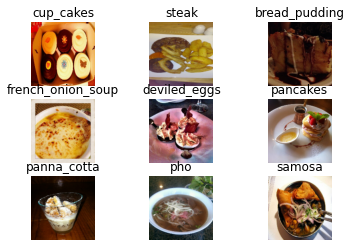

In [11]:
i = 0
for image, label in train_dataset.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")
    i = i + 1

## Batching the datasets

In [12]:
BATCH_SIZE = 32
validation_dataset = validation_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

## Creating a test set

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 632
Number of test batches: 158


## Performance tuning

<https://www.tensorflow.org/guide/data_performance>

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation


In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

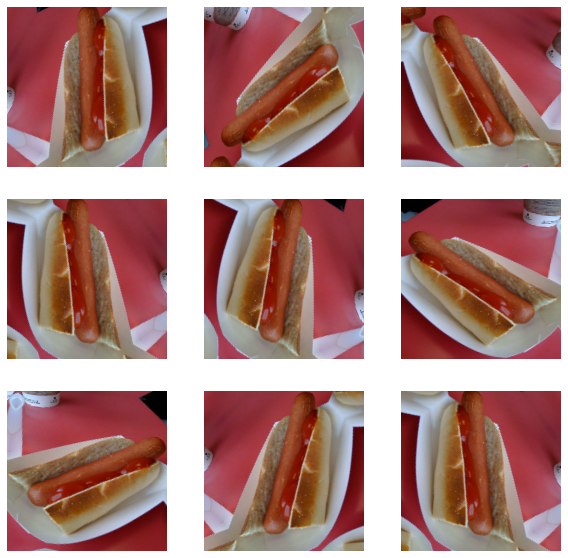

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## Create the base model from the pre-trained model MobileNet V2

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

ResourceExhaustedError: OOM when allocating tensor with shape[32,32,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

## Feature extraction

In [ ]:
base_model.trainable = False

In [74]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Classification head

In [75]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


## Redesign needed...

The classification layer needs a redesign because two classes for 101 categories is obviously a problem...

In the example offered by TF documentation, output = binary. We need more than 1 because we want to recongize 101 foods.
See this <https://stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension>

So we change BinaryCrossEntropy to Category Entropy in the compile step.

In [76]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
##%% md
## Assemble and compile the model

(32, 1)


In [77]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [78]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0   

In [80]:
len(model.trainable_variables)

2

## Train the model

In [81]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

632/632 [==============================] - 72s 91ms/step - loss: nan - accuracy: 0.0101   

In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -35.71
initial accuracy: 0.01


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
2368/2368 [==============================] - 109s 45ms/step - loss: -2617.8770 - accuracy: 0.0100 - val_loss: -4857.9951 - val_accuracy: 0.0101

## Showing the very poor performance of the model

Sorry if I'm not a TF architect :-)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
